<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
ELEC PRICE PREDICTION CAPSTONE:</font>  

<font size='4'>ARIMA Models for Continuous Targets</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Manu Kalia Project Submission<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; DSI-7-SF<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15-May-2019<br>
</font>

---


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Function-Definitions" data-toc-modified-id="Function-Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function Definitions</a></span></li><li><span><a href="#Load-Pickles:--Train/Test-Dataframes-&amp;--Scaled-Arrays" data-toc-modified-id="Load-Pickles:--Train/Test-Dataframes-&amp;--Scaled-Arrays-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Pickles:  Train/Test Dataframes &amp;  Scaled Arrays</a></span></li><li><span><a href="#Augmented-Dickey-Fuller-Test" data-toc-modified-id="Augmented-Dickey-Fuller-Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Augmented Dickey-Fuller Test</a></span></li><li><span><a href="#Choose-Values-for-p-and-q" data-toc-modified-id="Choose-Values-for-p-and-q-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Choose Values for <code>p</code> and <code>q</code></a></span></li><li><span><a href="#Gridsearch-to-find-lowest-MSE-params-for-p,-d,-q" data-toc-modified-id="Gridsearch-to-find-lowest-MSE-params-for-p,-d,-q-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Gridsearch to find lowest MSE params for <code>p</code>, <code>d</code>, <code>q</code></a></span></li><li><span><a href="#Instantiate-and-fit-the-models-with-best-params" data-toc-modified-id="Instantiate-and-fit-the-models-with-best-params-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Instantiate and fit the models with best params</a></span></li></ul></div>

---

## Imports

In [1]:
import pandas as pd
import numpy as np

import pickle
import wget, os
import time
import glob
import pytz

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# 
register_matplotlib_converters()
%matplotlib inline
sns.set_style('whitegrid')

In [31]:
# from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error


---

## Function Definitions

In [12]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

---

## Load Pickles:  Train/Test Dataframes &  Scaled Arrays

In [6]:
with open('../data/processed/train.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test.pkl', 'rb') as f:
    test = pickle.load(f)
    
with open('../data/processed/train_sc.pkl', 'rb') as f:
    train_sc = pickle.load(f)
    
with open('../data/processed/test_sc.pkl', 'rb') as f:
    test_sc = pickle.load(f)

---

## Augmented Dickey-Fuller Test

P-value for both target variables are **extremely** low (`1.4e-19` and `6.5e-28` for day-ahead and hour-ahead prices, respectively), so they both pass the the test for stationarity, assuming some low threshold for $\alpha$ such as 0.05 or 0.01  

Differencing is not required, so set `$d = 0$`.

In [14]:
interpret_dftest(adfuller(train['dam_price_per_mwh']))

Test Statistic   -1.086989e+01
p-value           1.377061e-19
dtype: float64

In [15]:
interpret_dftest(adfuller(train['hasp_price_per_mwh']))

Test Statistic   -1.516645e+01
p-value           6.481191e-28
dtype: float64

---

## Choose Values for `p` and `q`

 * Endogenous variable: **DA price** ... $p=1$ ... sharp cutoff in PACF bet. lag-1 & lag-2; ACF lag-1 > 0  
 * Endogenous variable: **DA price** ... $q=0$ ... ACF lag-1 is not negative  
 <br/>
 * Endogenous variable: **HA price** ... $p=1$ ... sharp cutoff in PACF bet. lag-1 & lag-2; ACF lag-1 > 0  
 * Endogenous variable: **HA price** ... $q=0$ ... ACF lag-1 is not negative  
 <br/>

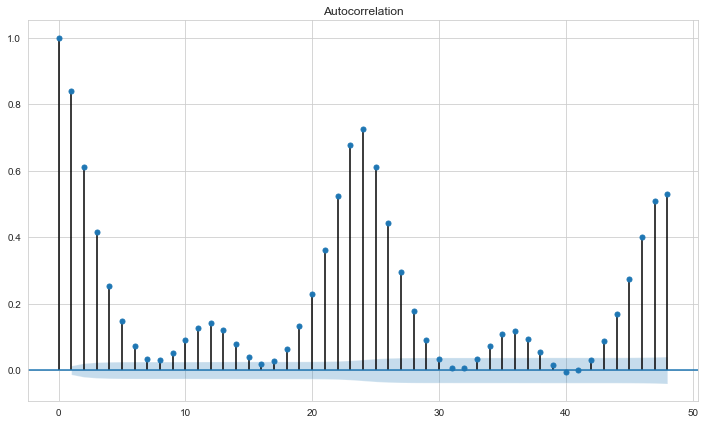

In [26]:
fig, ax = plt.subplots(figsize=(12,7))
plot_acf(train['dam_price_per_mwh'], lags=24*2, ax=ax);

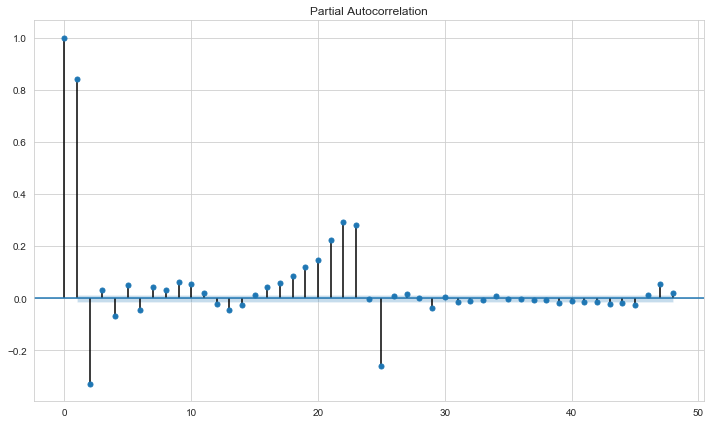

In [27]:
fig, ax = plt.subplots(figsize=(12,7))
plot_pacf(train['dam_price_per_mwh'], lags=24*2, ax=ax);

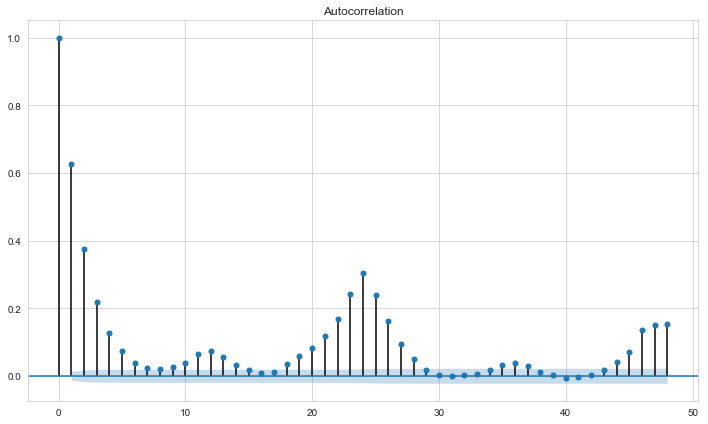

In [28]:
fig, ax = plt.subplots(figsize=(12,7))
plot_acf(train['hasp_price_per_mwh'], lags=24*2, ax=ax);

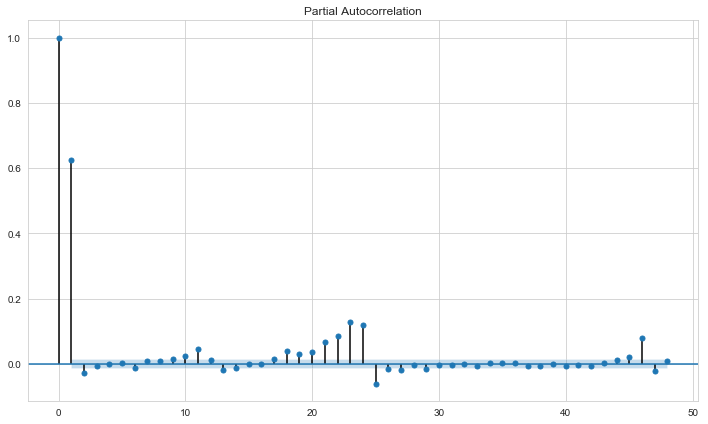

In [29]:
fig, ax = plt.subplots(figsize=(12,7))
plot_pacf(train['hasp_price_per_mwh'], lags=24*2, ax=ax);

---

## Gridsearch to find lowest MSE params for `p`, `d`, `q`

(for `DAM` and `HASP` prices as endogenous variables)



In [34]:
# Matt Brem's grid search loop

for p in range(7):
    for d in range(7):
        for q in range(7):
            try:
                dam_arima = ARIMA(endog = train['dam_price_per_mwh'].astype('float32'), # Y variable
                              order = (p, d, q)) # (p, d, q)
                dam_model = dam_arima.fit()
                dam_preds = dam_model.predict()
                print(f'MSE for (p={p}, d={d}, q={q}) ... {mean_squared_error(train["dam_price_per_mwh"], dam_preds)}')
            
            except:
                pass

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=0) ... 426.36566006002545
MSE for (p=0, d=0, q=1) ... 180.3241706704521


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=1, d=0, q=0) ... 124.97718666381336


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=1) ... 111.66488765092917


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=2) ... 111.55511096243268


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=3) ... 110.39468640392809


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=4) ... 110.38667558541545


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=5) ... 109.25572059509933


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=6) ... 108.29985883596329


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=2, d=0, q=0) ... 111.56404229239372


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=1) ... 111.37721489371023


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=2) ... 111.03321972408797


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=3) ... 110.38066473314079


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=4) ... 108.18060959473196


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=5) ... 107.49626757974505


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=6) ... 106.31032348631769


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=3, d=0, q=0) ... 111.46317265985816


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=1) ... 109.05347072531049


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=2) ... 110.35319377608806


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=3) ... 103.55945664227609


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=4) ... 104.4054354121607


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=5) ... 105.99956291923954


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=6) ... 102.77035503267885


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=4, d=0, q=0) ... 110.92355529087577


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=1) ... 110.31973155695584


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=2) ... 110.28302082465274


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=3) ... 103.13846640781675


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=4) ... 103.03437551766501


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=5) ... 103.03288652474689


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=6) ... 101.24055096374197


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=5, d=0, q=0) ... 110.62583239298174


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=1) ... 107.7200902589757


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=2) ... 107.4920985567981


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=3) ... 103.06192627273367


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=4) ... 103.03379421461386


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=5) ... 102.94990064129885


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=6) ... 102.59222162572325


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=6, d=0, q=0) ... 110.39374903440836


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=1) ... 107.7165222291897


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=2) ... 107.62895871532776


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=3) ... 103.42329892593925


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=4) ... 103.73682179507146


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=5) ... 101.93392995186537


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=6) ... 101.9323907196177


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

In [41]:
# Matt Brem's grid search loop

for p in range(7):
    for d in range(7):
        for q in range(7):
            try:
                hasp_arima = ARIMA(endog = train['hasp_price_per_mwh'].astype('float32'), # Y variable
                              order = (p, d, q)) # (p, d, q)
                hasp_model = hasp_arima.fit()
                hasp_preds = hasp_model.predict()
                print(f'MSE for (p={p}, d={d}, q={q}) ... {mean_squared_error(train["hasp_price_per_mwh"], hasp_preds):.2f}')
            
            except:
                pass

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=0) ... 1677.48
MSE for (p=0, d=0, q=1) ... 1159.42
MSE for (p=0, d=0, q=2) ... 1058.84


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=3) ... 1032.00


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=4) ... 1025.19


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=5) ... 1021.38


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=6) ... 1020.54


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=1, d=0, q=0) ... 1021.46
MSE for (p=1, d=0, q=1) ... 1020.64


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=2) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=3) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=4) ... 1020.57


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=5) ... 1014.13


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=6) ... 1012.02


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=2, d=0, q=0) ... 1020.62


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=1) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=2) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=3) ... 1012.49


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=4) ... 1012.35


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=5) ... 1012.31


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=6) ... 1011.87


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=0) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=1) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=2) ... 1010.15


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=3) ... 1010.14


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=4) ... 1012.32


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=5) ... 1012.30


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=6) ... 1013.27


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=4, d=0, q=0) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=1) ... 1012.39


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=2) ... 1010.14


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=3) ... 1009.73


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=4) ... 1001.30


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=5) ... 1000.78


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

MSE for (p=4, d=0, q=6) ... 992.96


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=5, d=0, q=0) ... 1020.57


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=1) ... 1012.20


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=2) ... 1012.22


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=3) ... 1009.70


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=4) ... 1000.71


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=5) ... 1000.68


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=6) ... 992.65


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=0) ... 1020.43


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=1) ... 1012.04


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=2) ... 1012.17


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=3) ... 1009.45


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=4) ... 1000.68


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=5) ... 999.52


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=6) ... 991.07


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

## Instantiate and fit the models with best params

In [39]:
p = 4
d = 0
q = 6

dam_arima406 = ARIMA(endog = train['dam_price_per_mwh'].astype('float32'),  # Y variable
                     order = (p, d, q))                                     # (p, d, q)
dam_arima406_model = dam_arima406.fit()
dam_arima406_preds = dam_arima406_model.predict()

print(f'MSE for (p={p}, d={d}, q={q}) ... {mean_squared_error(train["dam_price_per_mwh"], dam_arima406_preds):.2f}')


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=6) ... 101.24


In [40]:
with open('../fitted_models/dam_arima406_model.pkl', 'wb') as f:
    pickle.dump(dam_arima406_model, f)
    
with open('../data/predictions/dam_arima406_preds.pkl', 'wb') as f:
    pickle.dump(dam_arima406_preds, f)

In [43]:
p = 6
d = 0
q = 6

hasp_arima606 = ARIMA(endog = train['hasp_price_per_mwh'].astype('float32'),  # Y variable
                     order = (p, d, q))                                     # (p, d, q)
hasp_arima606_model = hasp_arima606.fit()
hasp_arima606_preds = hasp_arima606_model.predict()

print(f'MSE for (p={p}, d={d}, q={q}) ... {mean_squared_error(train["hasp_price_per_mwh"], hasp_arima606_preds):.2f}')


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=6) ... 991.07


In [44]:
with open('../fitted_models/hasp_arima606_model.pkl', 'wb') as f:
    pickle.dump(hasp_arima606_model, f)
    
with open('../data/predictions/hasp_arima606_preds.pkl', 'wb') as f:
    pickle.dump(hasp_arima606_preds, f)